In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

# functions
# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data

# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate helical fraction
def betastrand_fraction(ss_line):
    beta_chars = {'E', 'B'}
    n_residues = len(ss_line)
    n_beta = sum(1 for c in ss_line if c in beta_chars)
    return n_beta / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

def autocorrelation_fft(x):
    x = np.asarray(x)
    x -= np.mean(x)
    f = np.fft.fft(x, n=2*len(x))
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= acf[0]
    return acf

def autocorrelation(x):
    x = np.asarray(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size // 2:]  # keep non-negative lags
    result /= result[0]  # normalize
    return result

def vector_autocorrelation_fft(X):
    X = np.asarray(X)
    X_centered = X - np.mean(X, axis=0)
    n = X.shape[0]
    nfft = 2 * n
    f = np.fft.fft(X_centered, n=nfft, axis=0)
    ps = np.sum(f * np.conjugate(f), axis=1).real
    acf = np.fft.ifft(ps)[:n].real
    acf /= acf[0]
    return acf

def weighted_autocorrelation(x, w):
    """
    Weighted autocorrelation function.
    x : array of shape (n,)
    w : array of shape (n,)
    returns : array of length n (normalized ACF)
    """
    x = np.asarray(x)
    w = np.asarray(w)
    n = len(x)

    # Weighted mean
    x_mean = np.sum(w * x) / np.sum(w)
    x_centered = x - x_mean

    acf = np.zeros(n)
    for lag in range(n):
        valid = n - lag
        num = np.sum(w[:valid] * w[lag:] * x_centered[:valid] * x_centered[lag:])
        den = np.sum(w[:valid] * w[lag:])
        acf[lag] = num / den if den > 0 else np.nan

    # Normalize
    acf /= acf[0]
    return acf

def weighted_autocorrelation_fft(x, w):
    """
    Compute weighted autocorrelation function using FFT.
    x : array (n,)
    w : array (n,)
    Returns normalized weighted ACF (length n)
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    n = len(x)
    
    # Weighted mean
    x_mean = np.sum(w * x) / np.sum(w)
    x_centered = x - x_mean

    # Zero-pad to avoid circular convolution
    nfft = 2 * n

    # FFTs
    fw = np.fft.fft(w, nfft)
    fxw = np.fft.fft(w * x_centered, nfft)

    # Convolution in frequency domain (numerator & denominator)
    num = np.fft.ifft(fxw * np.conjugate(fxw)).real[:n]
    den = np.fft.ifft(fw * np.conjugate(fw)).real[:n]

    # Normalize each lag’s numerator by denominator
    acf = num / den
    acf /= acf[0]  # normalize so C(0) = 1

    return acf

def auc_until_negative(x, y, tolerance = 0.0):
    """
    Compute the area under the curve (AUC) using np.trapz,
    integrating only until the first negative y value.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # find first negative index
    neg_idx = np.where(y < 0 + tolerance)[0]
    if neg_idx.size > 0:
        end = neg_idx[0]
    else:
        end = len(y)

    # integrate up to that index (inclusive of last positive point)
    return np.trapz(y[:end], x[:end])

# paths
output_path = './plots_ACTR/'
prod_name = 'ACTR'
path = '../REST2/ACTR/PROD_REST2/'
path_biased = '../OPES_multiT/../OPES_multiT/ACTR/NEW_PRODUCTION_300K_2fs_80steps/alldata/'
opes_data_path = '../analysis/plots_ACTR/'

In [2]:
# accelaration factors: how much faster are OPES simulations sampling?
# error bar estimate: based on err1 = 1/sqrt(n1) --> err1 / err2 = sqrt(n2) / sqrt(n1) , (err1 / err2) **2 = n2 / n (factor)
# error bar estimate from autocorr of relevant CV
# these quantifies are estimated from time-arrays of rg, alpharmsd, and dssp

nsims_REST2 = 20 # demuxed trajectories
nsims_biased = 5

kb=0.008314
T0 = 300
T=300
kbt = kb*T0

dssp_map_simple = {
    "H": 1,  # alpha helix
    "G": 1,  # 3_10 helix
    "I": 1,  # pi helix
    "E": 2,  # beta strand
    "B": 2,  # beta bridge
    "T": 3,  # turn
    "S": 3,  # bend
    "P": 3,  # PPII
    "C": 3,  # coil
    "-": 3,  # sometimes DSSP uses '-'
    "~": 3,  # sometimes DSSP uses '-'
}

dssp_map = {
    "H": 1,  # alpha helix
    "G": 2,  # 3_10 helix
    "I": 3,  # pi helix
    "E": 4,  # beta strand
    "B": 5,  # beta bridge
    "T": 6,  # turn
    "S": 7,  # bend
    "P": 8,  # PPII
    "C": 9,  # coil
    "-": 9,  # sometimes DSSP uses '-'
    "~": 9,  # sometimes DSSP uses '-'
}

vectorized_map = np.vectorize(lambda x: dssp_map.get(x, 0))  # default=0 for any unknown
vectorized_map_simple = np.vectorize(lambda x: dssp_map_simple.get(x, 0))  # default=0 for any unknown

descriptors = ['R$_g$', 'Helicity', 'dssp$_{simple}$', 'dssp$_{detailed}$']
file_basenames = ['CVS_DATA', 'CVS_DATA', 'dssp', 'dssp']

# load data

# REST2 MD
for i in range(nsims_REST2):
    if i==0:
        data_unb = np.loadtxt(path+f'DEMUX/CVS_DATA.{i}')
        time_unb = np.arange(data_unb.shape[0]) * 40 / 1e3 # in ns
        mask_unb = time_unb <= 1250.0
        data_unb = data_unb[mask_unb]
        with open(path+f'DEMUX/dssp_{i}.dat') as f:
            dssp = [line.strip() for line in f]
        dssp_split_unb = np.array([list(s) for s in dssp])[mask_unb]
    else:
        tmpdata_unb = np.loadtxt(path+f'DEMUX/CVS_DATA.{i}')
        time_unb = np.arange(tmpdata_unb.shape[0]) * 40 / 1e3 # in ns
        mask_unb = (time_unb <= 1250.0) & (time_unb > 0.0)
        tmpdata_unb = tmpdata_unb[mask_unb]
        with open(path+f'DEMUX/dssp_{i}.dat') as f:
            dssp = [line.strip() for line in f]
        tmpdssp_split_unb = np.array([list(s) for s in dssp])[mask_unb]
        data_unb = np.concatenate((data_unb, tmpdata_unb), axis=0)
        dssp_split_unb = np.concatenate((dssp_split_unb, tmpdssp_split_unb), axis=0)
time_unb = np.arange(data_unb.shape[0]) * 40 / 1e3 # in ns

# biased MD
for i in range(nsims_biased):
    if i==0:
        bias_opes = read_colvar(path_biased+f"COLVAR.{i}")[::4]
        data_opes = np.loadtxt(path_biased+f'CVS_DATA.{i}')[::4] # subsample to have the same number of frames as for REST2
        time_opes = np.arange(data_opes.shape[0]) * 40 / 1e3 # in ns
        mask_opes = time_opes <= 5000.0 
        data_opes = data_opes[mask_opes]
        bias_opes = bias_opes[mask_opes]
        with open(path_biased+f'dssp{i}.dat') as f:
            dssp = [line.strip() for line in f]
        dssp_split_opes = np.array([list(s) for s in dssp])[::4][mask_opes]
    else:
        tmpbias_opes = read_colvar(path_biased+f"COLVAR.{i}")[::4]
        tmpdata_opes = np.loadtxt(path_biased+f'CVS_DATA.{i}')[::4] # subsample to have the same number of frames as for REST2
        tmptime_opes = np.arange(tmpdata_opes.shape[0]) * 40 / 1e3 # in ns
        mask_opes = (tmptime_opes <= 5000.0) & (tmptime_opes > 0.0)
        tmpdata_opes = tmpdata_opes[mask_opes]
        tmpbias_opes = tmpbias_opes[mask_opes]
        with open(path_biased+f'dssp{i}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        tmpdssp_split = np.array([list(s) for s in tmpdssp])[::4][mask_opes]
        # append
        data_opes = np.concatenate((data_opes, tmpdata_opes), axis=0)
        bias_opes = np.concatenate((bias_opes, tmpbias_opes), axis=0)
        dssp_split_opes = np.concatenate((dssp_split_opes, tmpdssp_split), axis=0)

bias = bias_opes[:,2]
ene = bias_opes[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)

print(data_opes.shape)
print(w.shape)
print(data_unb.shape)
print(dssp_split_opes.shape)
print(dssp_split_unb.shape)
print(time_unb.shape)


(625001, 3)
(625001,)
(625001, 3)
(625001, 71)
(625001, 71)
(625001,)


In [3]:
# base replica 300 K REST2 data
i=0
BASE_DATA_UNB = np.loadtxt(path+f'dir{i}/CVS_DATA')
with open(path+f'dir{i}/dssp.dat') as f:
    dssp = [line.strip() for line in f]
BASE_DSSP_SPLIT_UNB = np.array([list(s) for s in dssp])
print(BASE_DATA_UNB.shape)
print(BASE_DSSP_SPLIT_UNB.shape)

(37911, 3)
(37911, 71)


R$_g$
2.046412248371185
11
10
0.03616361251158284
0.02815893472484345
1.6493437239362634
Helicity
3.042014036110891
11
11
0.2879005254045818
0.4128569259268109
0.4862792808941707
dssp$_{simple}$
0.7352681123711832
dssp$_{detailed}$


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


1.4346516236587556


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


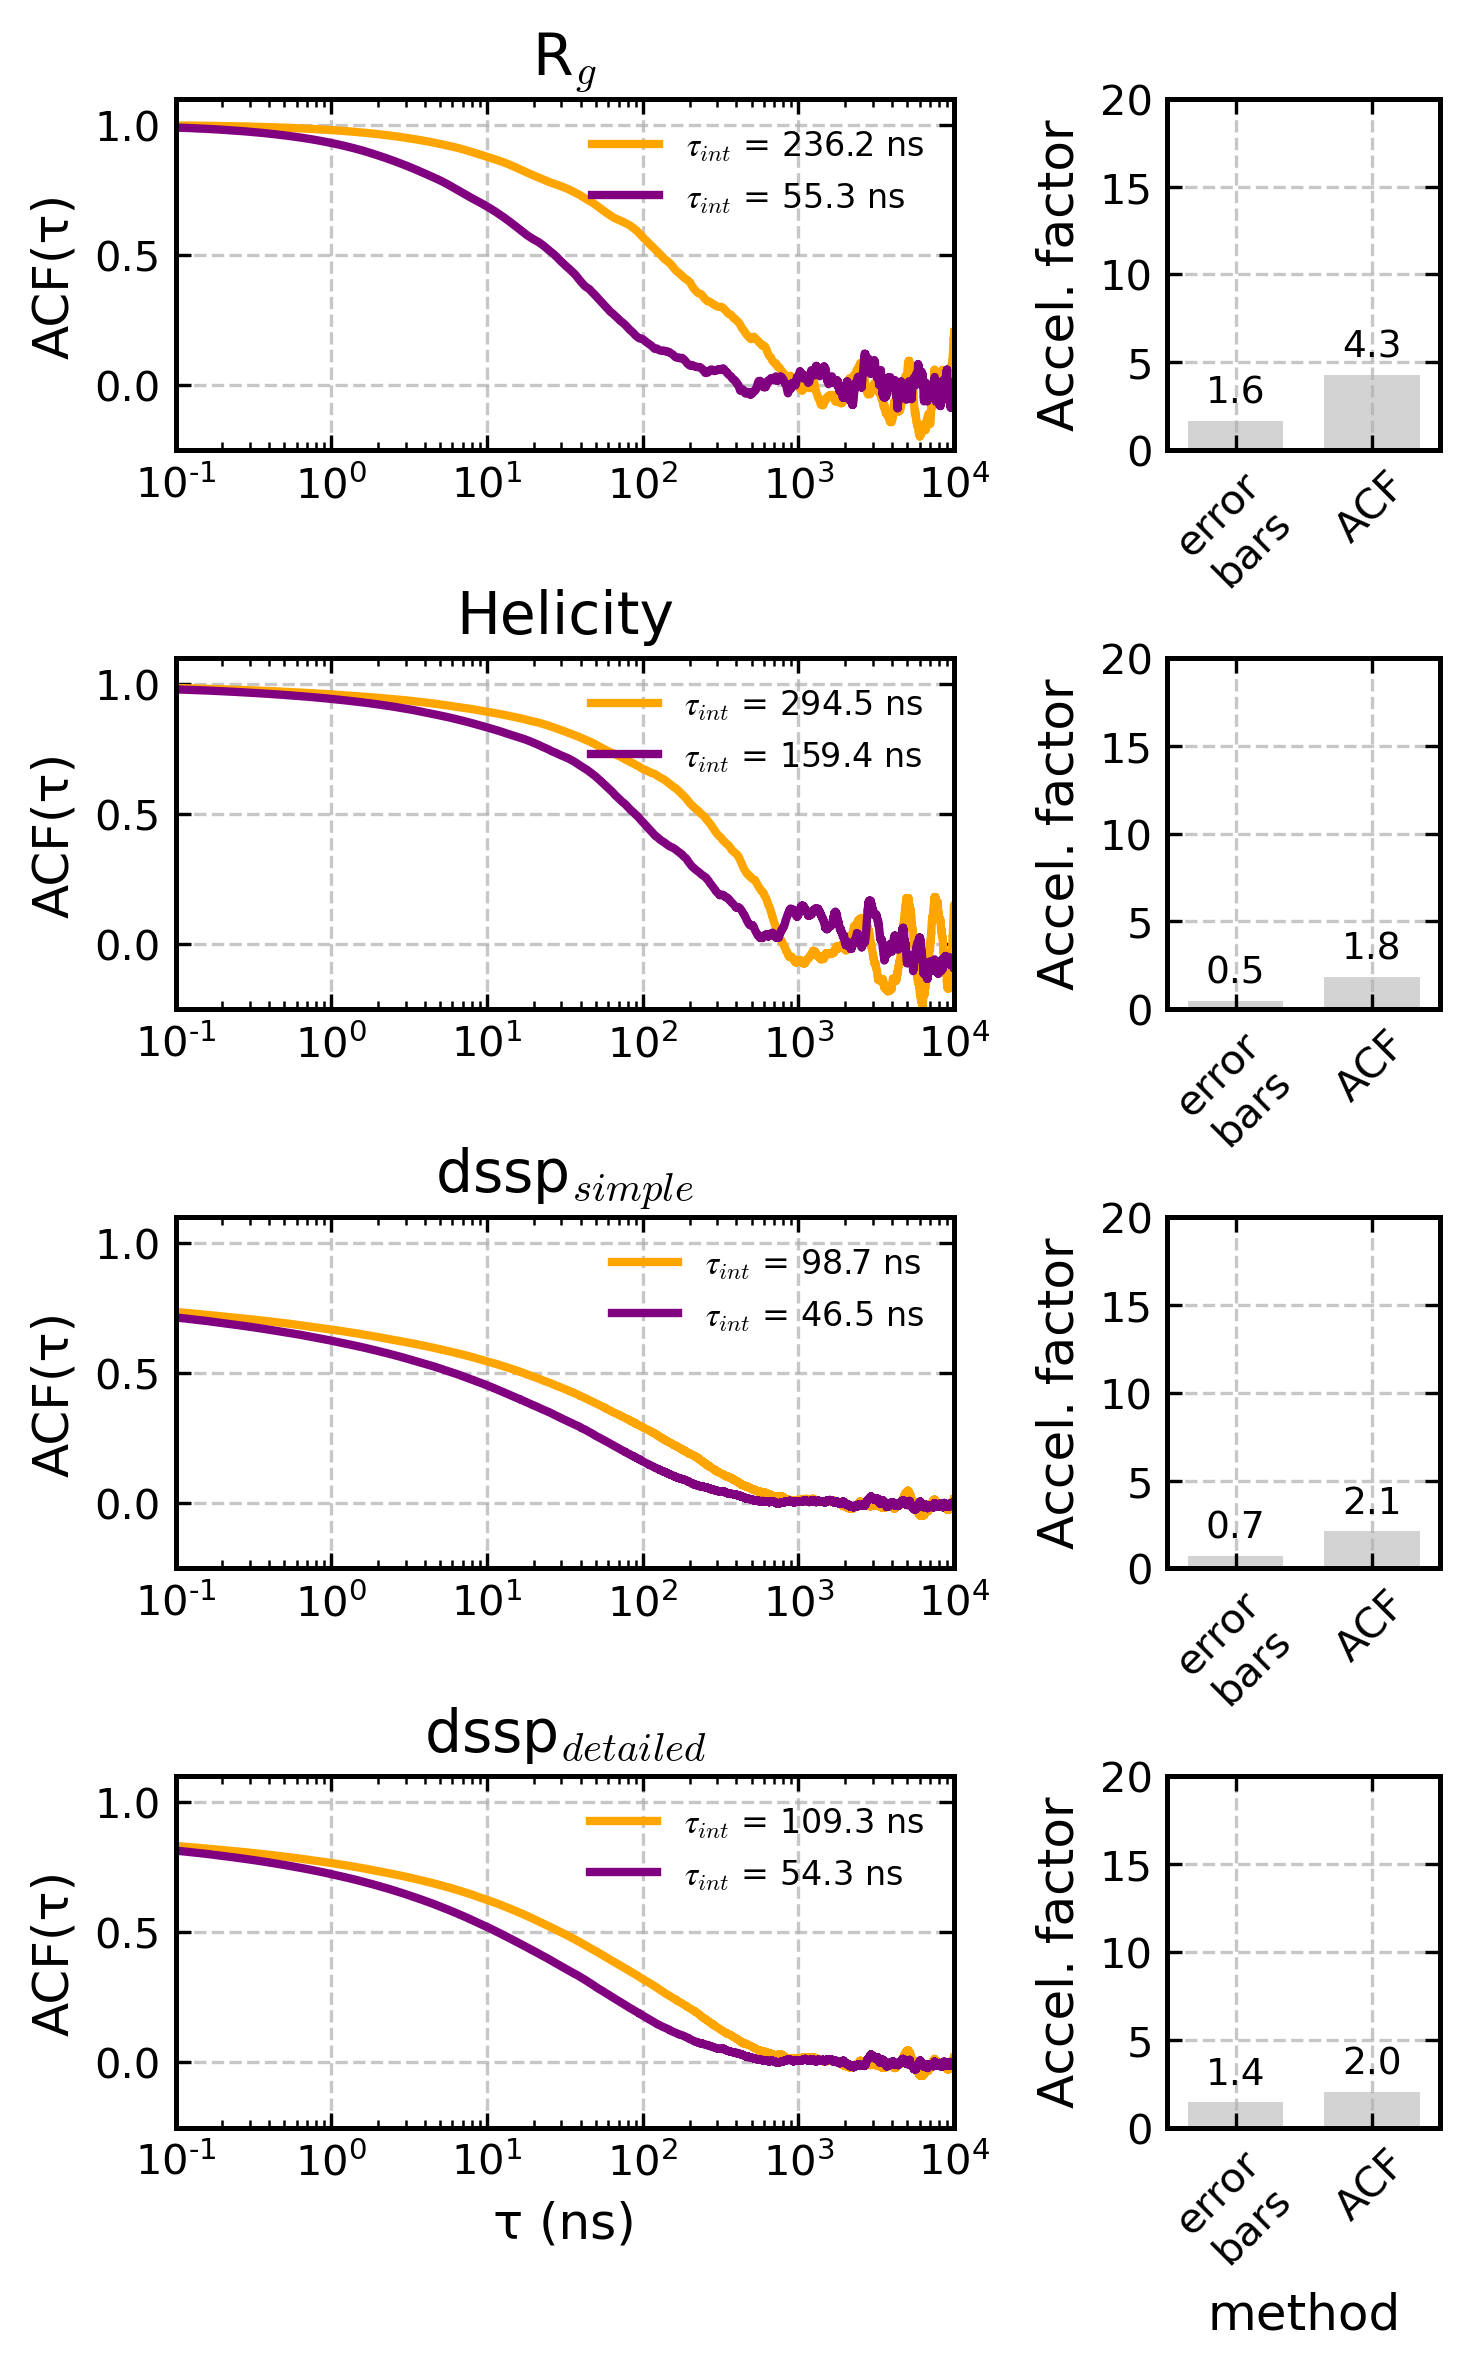

In [4]:
# initialise figure
# NOTE that the error bar acceleration factor for the dssp_detailed refers to the errors calculated on per-residue b-strand propensity, whereas
# the dssp_simple has errors from alpha-helix propensity

fig, axes = plt.subplots(
    nrows=len(descriptors), ncols=2, figsize=(5, 8), sharex=False, sharey=False, gridspec_kw={'width_ratios': [2, 0.7]})

for i, descriptor in enumerate(descriptors):
    print(descriptor)
    # STEP 1: blocking to get errorbars
    if descriptor=='R$_g$':
        DAT_UNB = BASE_DATA_UNB[:,1]
        DAT_UNB2 = data_unb[:,1]
        DAT_OPES_ALL = data_opes[:,1]
        mask = w != 0
        DAT_OPES = DAT_OPES_ALL[mask]
        weights_clean = w[mask]
    elif descriptor=='Helicity':
        DAT_UNB = BASE_DATA_UNB[:,2]
        DAT_UNB2 = data_unb[:,2]
        DAT_OPES_ALL = data_opes[:,2]
        mask = w != 0
        DAT_OPES = DAT_OPES_ALL[mask]
        weights_clean = w[mask]


    if descriptor=='R$_g$' or descriptor=='Helicity':
        print(np.mean(DAT_UNB))
        reblock_data = pyblock.blocking.reblock(DAT_UNB)
        optimal = int(pyblock.blocking.find_optimal_block(len(DAT_UNB), reblock_data)[0])
        print(optimal)
        if optimal ==len(reblock_data)-1: # avoid picking the last index
            optimal= optimal-1
        err_unb = reblock_data[optimal].std_err

        reblock_data = pyblock.blocking.reblock(DAT_OPES, weights=weights_clean)
        optimal = int(pyblock.blocking.find_optimal_block(len(DAT_OPES), reblock_data)[0])
        print(optimal)
        if optimal ==len(reblock_data)-1: # avoid picking the last index
            optimal= optimal-1
        err_opes = reblock_data[optimal].std_err

        print(err_unb)
        print(err_opes)
    
    elif 'simple' in descriptor:

        # load average helicity and get average error bars of residues that have > 0% helix, errors pre-computed with blocking
        df_unb = pd.read_csv(output_path+f'{prod_name}_perres_helicity.csv')
        df_unb = df_unb[df_unb['Fraction helix']>0]
        err_unb = np.mean(df_unb['±'])

        df_opes = pd.read_csv(opes_data_path+f'300K_perres_helicity_{T}K.csv')
        df_opes = df_opes[df_opes['Fraction helix']>0]
        err_opes = np.mean(df_opes['±'])

    elif 'detailed' in descriptor:

        # load average helicity and get average error bars of residues that have > 0% helix, errors pre-computed with blocking
        df_unb = pd.read_csv(output_path+f'{prod_name}_perres_bstrand.csv')
        df_unb = df_unb[df_unb['Fraction strand']>0]
        err_unb = np.mean(df_unb['±'])

        df_opes = pd.read_csv(opes_data_path+f'300K_perres_bstrand_300K.csv')
        df_opes = df_opes[df_opes['Fraction strand']>0]
        err_opes = np.mean(df_opes['±'])

    # calculate acceleration factor from errorbar ratio
    accel_errorbars = (err_unb / err_opes) ** 2


    # STEP 2: compute descriptor ACF
    if 'dssp' not in descriptor:
        acf_unb = autocorrelation_fft(DAT_UNB2)
        acf_opes = autocorrelation_fft(DAT_OPES_ALL)
    else:
        if 'simple' in descriptor:
            dssp_numeric_unb = vectorized_map_simple(dssp_split_unb).astype(int)
            dssp_numeric_opes = vectorized_map_simple(dssp_split_opes).astype(int)
        else:
            dssp_numeric_unb = vectorized_map(dssp_split_unb).astype(int)
            dssp_numeric_opes = vectorized_map(dssp_split_opes).astype(int)

        acf_unb = vector_autocorrelation_fft(dssp_numeric_unb)
        acf_opes = vector_autocorrelation_fft(dssp_numeric_opes)

    # STEP 3: compute ACF integral --> tau
    tau_int_unb = auc_until_negative(x = time_unb, y = acf_unb, tolerance=0.05)
    tau_int_opes = auc_until_negative(x = time_unb, y = acf_opes, tolerance=0.05)
    accel_tau_int = tau_int_unb / tau_int_opes

    print(accel_errorbars)

    # STEP 4: plot results
    label_unb = '$τ_{int}$ '+'= {:.1f} ns'.format(tau_int_unb)
    label_opes = '$τ_{int}$ '+'= {:.1f} ns'.format(tau_int_opes)
    axes[i, 0].plot(time_unb, acf_unb, linewidth=2., alpha=1., color = '#FFA500', label = label_unb)
    axes[i, 0].plot(time_unb, acf_opes, linewidth=2., alpha=1., color = 'purple', label = label_opes)
    axes[i, 0].set_title(descriptor)
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_ylabel('ACF(τ)')
    axes[i, 0].set_xlim(1e-1,1e4)
    axes[i, 0].set_ylim(-0.25, 1.1)
    axes[i, 0].legend(loc='upper right', ncol=1, fontsize = 8)

    if i==len(descriptors)-1:
        axes[i, 0].set_xlabel('τ (ns)')

    # right panels
    axes[i, 1].bar(0.25, height=accel_errorbars, width=0.35, color='lightgrey')
    axes[i, 1].bar(0.75, height=accel_tau_int, width=0.35, color='lightgrey')
    axes[i, 1].set_xlim(0, 1.)
    axes[i, 1].set_ylim(0,20)
    axes[i, 1].set_xticks([0.25, 0.75])
    axes[i, 1].set_xticklabels(['error\nbars', 'ACF'], rotation=0)
    axes[i, 1].tick_params(axis='x', rotation=45)
    axes[i, 1].set_ylabel('Accel. factor')

    # annotate bars with values
    axes[i, 1].text(
        0.25, accel_errorbars + 0.03 * axes[i, 1].get_ylim()[1],
        f"{accel_errorbars:.1f}",
        ha='center', va='bottom', fontsize=9
    )
    axes[i, 1].text(
        0.75, accel_tau_int + 0.03 * axes[i, 1].get_ylim()[1],
        f"{accel_tau_int:.1f}",
        ha='center', va='bottom', fontsize=9
    )

    if i==len(descriptors)-1:
        axes[i, 1].set_xlabel('method')


plt.tight_layout()

plt.savefig(output_path+f"{prod_name}_accel_analysis.pdf")


R$_g$
2.046412248371185
11
0.03616361251158284
0.0278


/tmp/ipykernel_3848099/3979351059.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  err_opes = float(pd.read_csv(opes_data_path+f"300K_Rg_at_300K.csv")['±'])


1.6922090858236003
Helicity
3.042014036110891
11
0.2879005254045818
0.4145


/tmp/ipykernel_3848099/3979351059.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  err_opes = float(pd.read_csv(opes_data_path+f"300K_alphaRMSD_at_300K.csv")['±'])


0.4824317089826378
dssp$_{simple}$
0.7352681123711832
dssp$_{detailed}$


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


1.4346516236587556


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


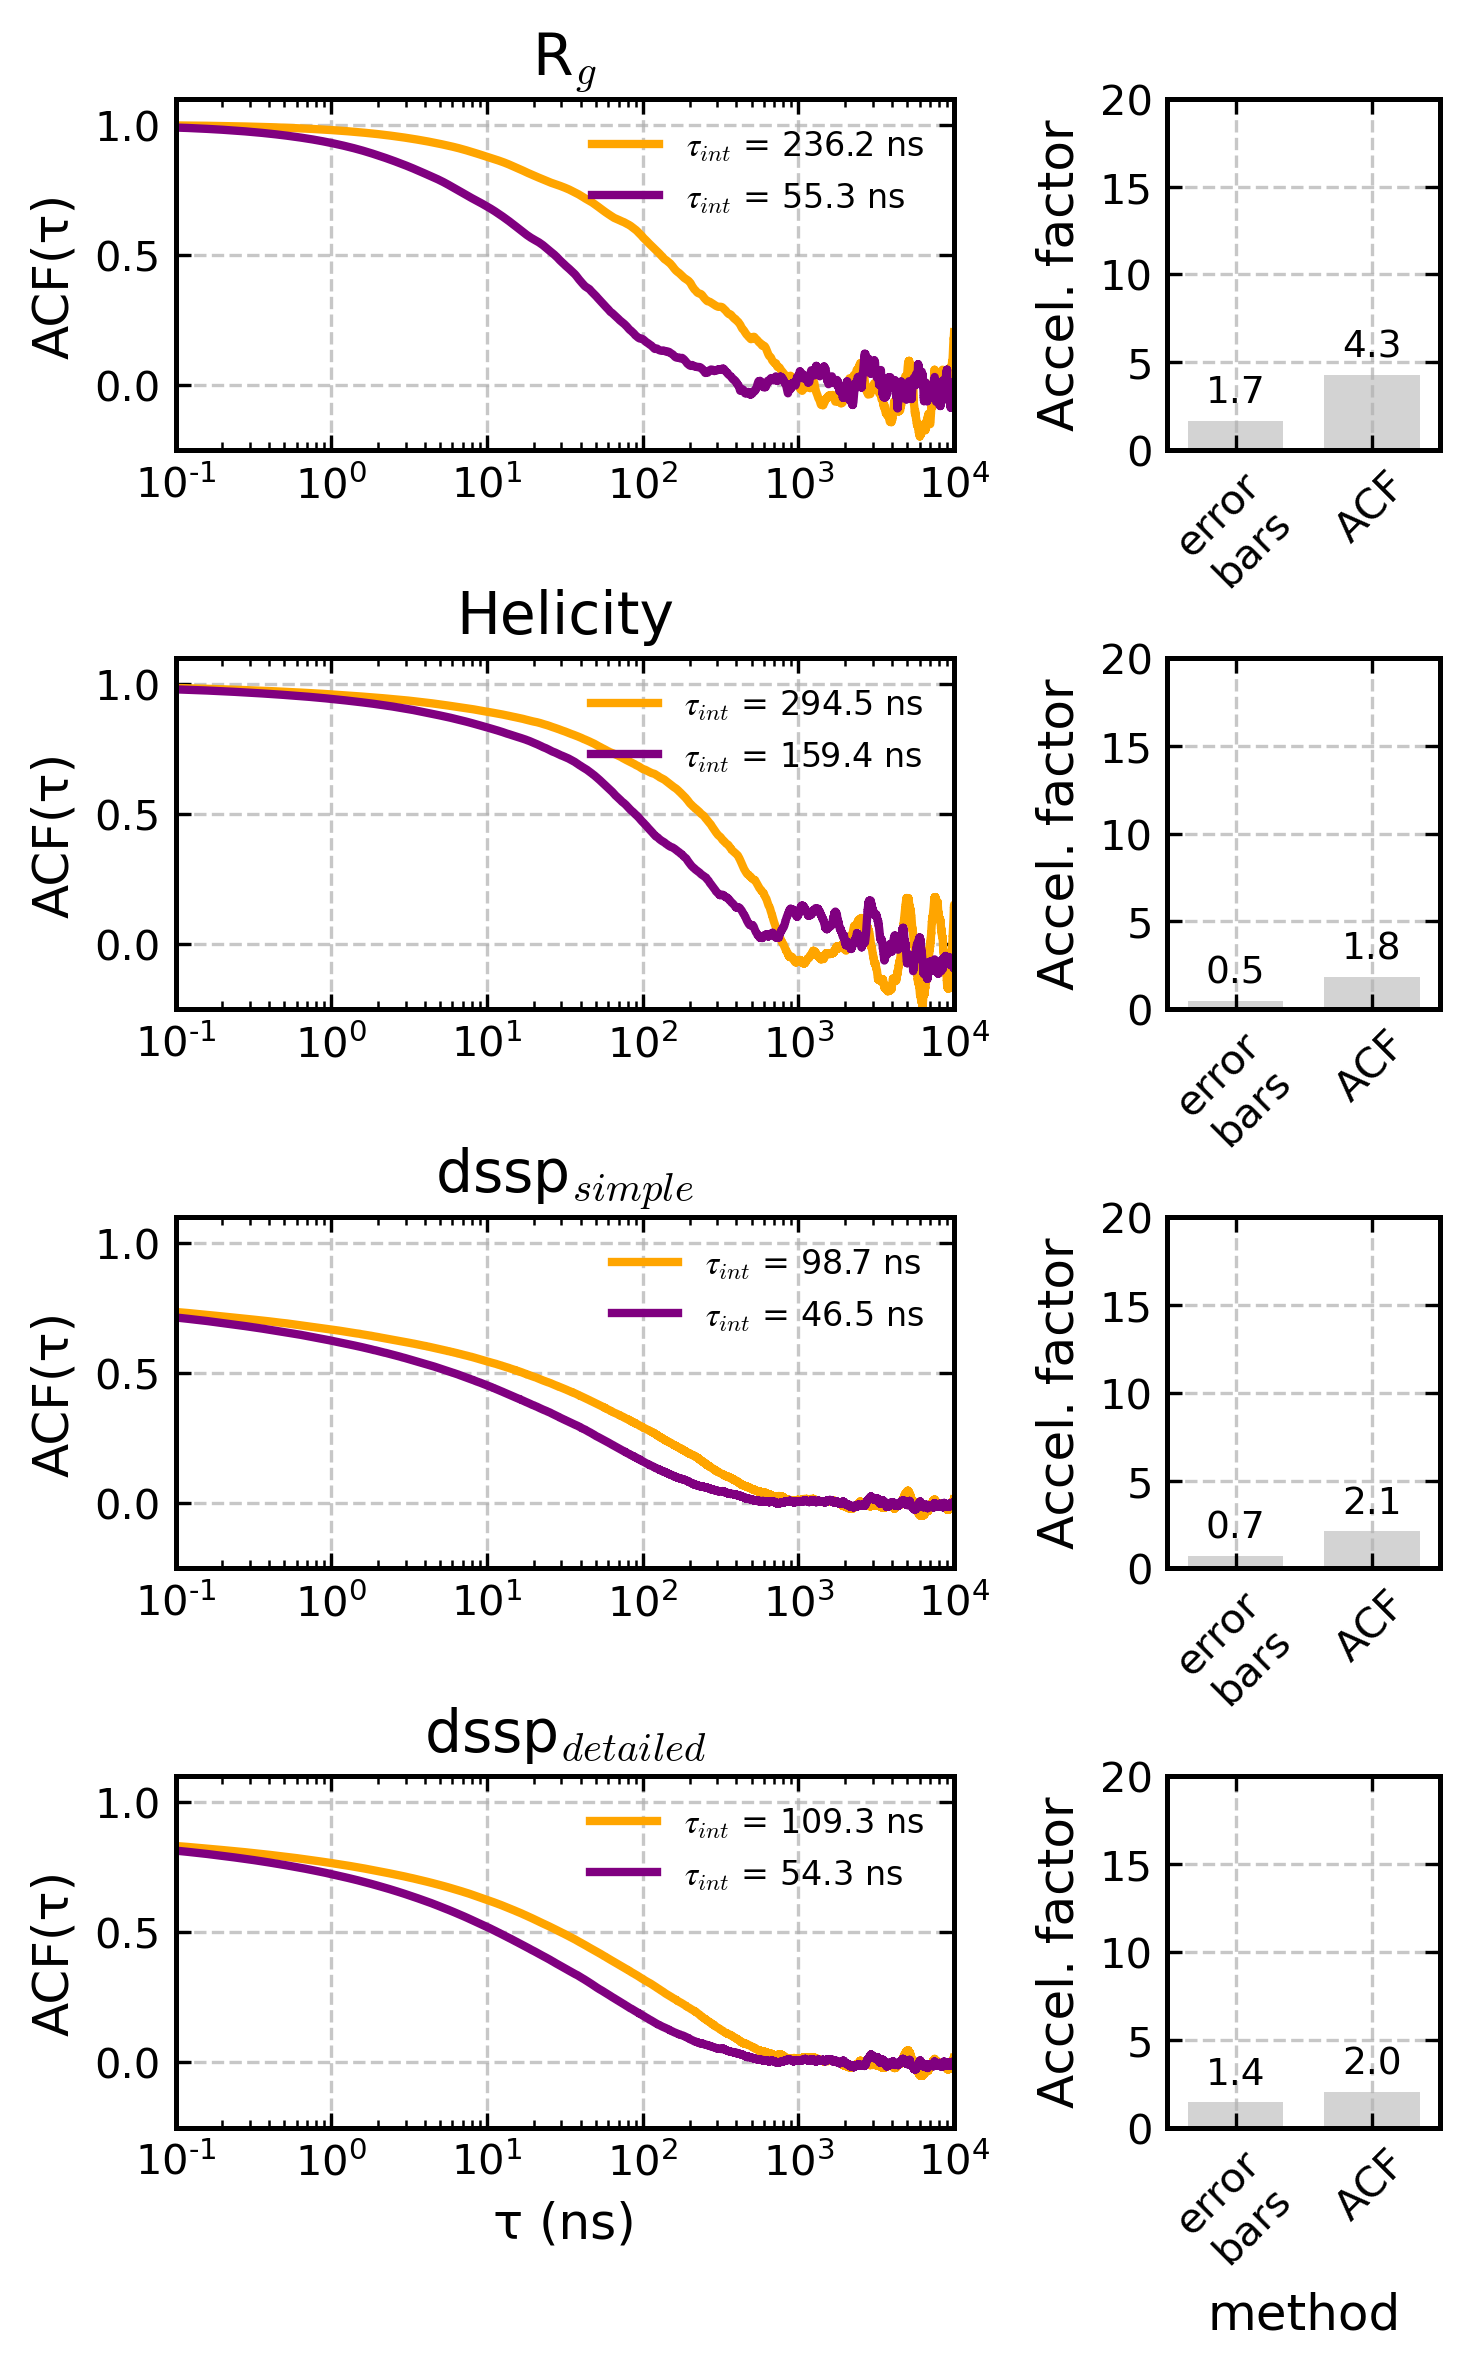

In [4]:
# initialise figure - with full OPES errors
# NOTE that the error bar acceleration factor for the dssp_detailed refers to the errors calculated on per-residue b-strand propensity, whereas
# the dssp_simple has errors from alpha-helix propensity

fig, axes = plt.subplots(
    nrows=len(descriptors), ncols=2, figsize=(5, 8), sharex=False, sharey=False, gridspec_kw={'width_ratios': [2, 0.7]})

for i, descriptor in enumerate(descriptors):
    print(descriptor)
    # STEP 1: blocking to get errorbars
    if descriptor=='R$_g$':
        DAT_UNB = BASE_DATA_UNB[:,1]
        DAT_UNB2 = data_unb[:,1]
        DAT_OPES_ALL = data_opes[:,1]
        mask = w != 0
        DAT_OPES = DAT_OPES_ALL[mask]
        weights_clean = w[mask]
    elif descriptor=='Helicity':
        DAT_UNB = BASE_DATA_UNB[:,2]
        DAT_UNB2 = data_unb[:,2]
        DAT_OPES_ALL = data_opes[:,2]
        mask = w != 0
        DAT_OPES = DAT_OPES_ALL[mask]
        weights_clean = w[mask]


    if descriptor=='R$_g$' or descriptor=='Helicity':
        print(np.mean(DAT_UNB))
        reblock_data = pyblock.blocking.reblock(DAT_UNB)
        optimal = int(pyblock.blocking.find_optimal_block(len(DAT_UNB), reblock_data)[0])
        print(optimal)
        if optimal ==len(reblock_data)-1: # avoid picking the last index
            optimal= optimal-1
        err_unb = reblock_data[optimal].std_err

        # load
        if descriptor=='R$_g$':
            err_opes = float(pd.read_csv(opes_data_path+f"300K_Rg_at_300K.csv")['±'])
        elif descriptor=='Helicity':
            err_opes = float(pd.read_csv(opes_data_path+f"300K_alphaRMSD_at_300K.csv")['±'])

        print(err_unb)
        print(err_opes)
    
    elif 'simple' in descriptor:

        # load average helicity and get average error bars of residues that have > 0% helix, errors pre-computed with blocking
        df_unb = pd.read_csv(output_path+f'{prod_name}_perres_helicity.csv')
        df_unb = df_unb[df_unb['Fraction helix']>0]
        err_unb = np.mean(df_unb['±'])

        df_opes = pd.read_csv(opes_data_path+f'300K_perres_helicity_{T}K.csv')
        df_opes = df_opes[df_opes['Fraction helix']>0]
        err_opes = np.mean(df_opes['±'])

    elif 'detailed' in descriptor:

        # load average helicity and get average error bars of residues that have > 0% helix, errors pre-computed with blocking
        df_unb = pd.read_csv(output_path+f'{prod_name}_perres_bstrand.csv')
        df_unb = df_unb[df_unb['Fraction strand']>0]
        err_unb = np.mean(df_unb['±'])

        df_opes = pd.read_csv(opes_data_path+f'300K_perres_bstrand_300K.csv')
        df_opes = df_opes[df_opes['Fraction strand']>0]
        err_opes = np.mean(df_opes['±'])

    # calculate acceleration factor from errorbar ratio
    accel_errorbars = (err_unb / err_opes) ** 2


    # STEP 2: compute descriptor ACF
    if 'dssp' not in descriptor:
        acf_unb = autocorrelation_fft(DAT_UNB2)
        acf_opes = autocorrelation_fft(DAT_OPES_ALL)
    else:
        if 'simple' in descriptor:
            dssp_numeric_unb = vectorized_map_simple(dssp_split_unb).astype(int)
            dssp_numeric_opes = vectorized_map_simple(dssp_split_opes).astype(int)
        else:
            dssp_numeric_unb = vectorized_map(dssp_split_unb).astype(int)
            dssp_numeric_opes = vectorized_map(dssp_split_opes).astype(int)

        acf_unb = vector_autocorrelation_fft(dssp_numeric_unb)
        acf_opes = vector_autocorrelation_fft(dssp_numeric_opes)

    # STEP 3: compute ACF integral --> tau
    tau_int_unb = auc_until_negative(x = time_unb, y = acf_unb, tolerance=0.05)
    tau_int_opes = auc_until_negative(x = time_unb, y = acf_opes, tolerance=0.05)
    accel_tau_int = tau_int_unb / tau_int_opes

    print(accel_errorbars)

    # STEP 4: plot results
    label_unb = '$τ_{int}$ '+'= {:.1f} ns'.format(tau_int_unb)
    label_opes = '$τ_{int}$ '+'= {:.1f} ns'.format(tau_int_opes)
    axes[i, 0].plot(time_unb, acf_unb, linewidth=2., alpha=1., color = '#FFA500', label = label_unb)
    axes[i, 0].plot(time_unb, acf_opes, linewidth=2., alpha=1., color = 'purple', label = label_opes)
    axes[i, 0].set_title(descriptor)
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_ylabel('ACF(τ)')
    axes[i, 0].set_xlim(1e-1,1e4)
    axes[i, 0].set_ylim(-0.25, 1.1)
    axes[i, 0].legend(loc='upper right', ncol=1, fontsize = 8)

    if i==len(descriptors)-1:
        axes[i, 0].set_xlabel('τ (ns)')

    # right panels
    axes[i, 1].bar(0.25, height=accel_errorbars, width=0.35, color='lightgrey')
    axes[i, 1].bar(0.75, height=accel_tau_int, width=0.35, color='lightgrey')
    axes[i, 1].set_xlim(0, 1.)
    axes[i, 1].set_ylim(0,20)
    axes[i, 1].set_xticks([0.25, 0.75])
    axes[i, 1].set_xticklabels(['error\nbars', 'ACF'], rotation=0)
    axes[i, 1].tick_params(axis='x', rotation=45)
    axes[i, 1].set_ylabel('Accel. factor')

    # annotate bars with values
    axes[i, 1].text(
        0.25, accel_errorbars + 0.03 * axes[i, 1].get_ylim()[1],
        f"{accel_errorbars:.1f}",
        ha='center', va='bottom', fontsize=9
    )
    axes[i, 1].text(
        0.75, accel_tau_int + 0.03 * axes[i, 1].get_ylim()[1],
        f"{accel_tau_int:.1f}",
        ha='center', va='bottom', fontsize=9
    )

    if i==len(descriptors)-1:
        axes[i, 1].set_xlabel('method')


plt.tight_layout()

plt.savefig(output_path+f"{prod_name}_accel_analysis_fullOPES_errors.pdf")
